In [1]:
import cv2
import numpy as np
import os
import imutils
from imutils.perspective import four_point_transform
from skimage.segmentation import clear_border


In [2]:
path = '/home/raghav/Documents/Git/Sudoku_AR/images_test/002.jpg'

In [3]:
img = cv2.imread(path)
cv2.imshow('img',  img)
cv2.waitKey(0)

32

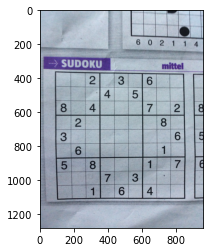

In [4]:
import matplotlib.pyplot as plt
plt.imshow(img)

In [14]:
img.shape[:2][0]

(1280, 961)

In [20]:
image=img

gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
gray = (gray - gray.min()) * int(255 / (gray.max() - gray.min()))
blurred = cv2.GaussianBlur(gray, (11, 11), 0)
thresh = cv2.adaptiveThreshold(blurred, 255,cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 29, 25)
thresh = cv2.bitwise_not(thresh)
# thresh = cv2.bitwise_not(thresh)
# plt.imshow(gray,cmap='gray')
# plt.imshow(blurred, cmap= 'gray')
# plt.imshow(thresh , cmap='gray')
contours= cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
img_digits = []
loc_digits = []

cnts=imutils.grab_contours(contours)
cnts=sorted(cnts,key=cv2.contourArea,reverse=True)
# initalize a contour
puzzlecnt=None

for c in cnts:
    # approximate the contour
    peri=cv2.arcLength(c,True)
    approx=cv2.approxPolyDP(c,0.02*peri,True)
    # if approx contour has 4 pts , then assume it as puzzle
    if (len(approx)==4):
        puzzlecnt=approx
        break
cv2.imshow('puzzle',puzzlecnt)
cv2.waitKey(0)
# for cnt in contours:
#     x, y, w, h = cv2.boundingRect(cnt)
#     y_true, x_true = y + h / 2, x + w / 2
#     if x_true < 10 or y_true < 10 or x_true > img.shape[:2][1] - 10 or y_true > img.shape[:2][0] - 10:
#         continue
#     if 15 < h < 50 and 210 < w * h < 900:
        
#         y1, y2 = y - 2, y + h + 2
#         border_x = max(1, int((y2 - y1 - w) / 2))
#         x1, x2 = x - border_x, x + w + border_x
#         # digit = im_prepro[y1:y2, x1:x2]
#         digit_cut = gray[max(y1, 0):min(y2, img.shape[:2][0]), max(x1, 0):min(x2, img.shape[:2][1])]
#         _, digit_thresh = cv2.threshold(digit_cut,0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
#         # digit_w_border = cv2.copyMakeBorder(digit, l_border, l_border, l_border, l_border,
#         #                                     cv2.BORDER_CONSTANT, None, 255)
#         img_digits.append(cv2.resize(digit_thresh, (28, 28), interpolation=cv2.INTER_NEAREST).reshape(28, 28, 1))
#         loc_digits.append([y_true, x_true])
        
#         cv2.imshow('digit',digit_thresh)
#         cv2.waitKey(0)

error: OpenCV(4.4.0) /tmp/pip-req-build-19zx5q4j/opencv/modules/highgui/src/precomp.hpp:137: error: (-215:Assertion failed) src_depth != CV_16F && src_depth != CV_32S in function 'convertToShow'


In [25]:
puzzle,warped = find_puzzle(img,True)

# initialize 9X9 sudoku board
board=np.zeros((9,9),dtype="int")

# calculating each cell
stepX = warped.shape[1] // 9
stepY = warped.shape[0] // 9

#  init a list to store (x,y) co-ordinate of each cell
cellLocs=[]
# Loop over grid locations
for y in range(0,9):
    row=[]
    for x in range(0,9):
        startX=x*stepX
        startY=y*stepY
        endX= (x+1)*stepX
        endY= (y+1)*stepY
        row.append((startX,startY,endX,endY))        
        cell=warped[startY:endY, startX:endX]
        
        
#         cv2.imshow('cell',thresh)
#         cv2.waitKey(0)
        
#  init a list to store (x,y) co-ordinate of each cell
# cellLocs=[]
# Loop over grid locations

        digit=extract_digit(cell,True)
#        
     
#         if digit is not None:
#             # resize to 28X28
#             roi=cv2.resize(digit,(28,28))
#             roi=roi.astype("float")/255.0
#             roi=img_to_array(roi)
#             roi=np.expand_dims(roi,axis=0)
#             # classify the digit
#             pred=model.predict(roi).argmax(axis=1)[0]
#             board[y,x]=pred
    # add the row
    
    cellLocs.append(row)
            



In [23]:
warped.shape[0]//9

83

In [19]:
def find_puzzle(image,debug=False):
    # convert image to grayscale and blur it slightly
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = (gray - gray.min()) * int(255 / (gray.max() - gray.min()))
    blurred = cv2.GaussianBlur(gray, (11, 11), 0)
    thresh = cv2.adaptiveThreshold(blurred, 255,cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 29, 25)
    thresh = cv2.bitwise_not(thresh)

    # for debugging
    if debug:
        cv2.imshow('Puzzle Thresh', thresh)
        cv2.waitKey(0)
    # find contours in threshold image and sort in descending order
    cnts=cv2.findContours(thresh.copy(),cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    cnts=imutils.grab_contours(cnts)
    cnts=sorted(cnts,key=cv2.contourArea,reverse=True)
    # initalize a contour
    puzzlecnt=None

    for c in cnts:
        # approximate the contour
        peri=cv2.arcLength(c,True)
        approx=cv2.approxPolyDP(c,0.02*peri,True)
        # if approx contour has 4 pts , then assume it as puzzle
        if (len(approx)==4):
            puzzlecnt=approx
            break
    # if puzzle contour is empty, raise an error
    if puzzlecnt is None:
        raise Exception(("Could not find sudoku puzzle outline."
                        "Try debugging your thresholding and contour steps."))
    # check to see if we are visualizing the outline of detected sudoku
    if debug:
        output=image.copy()
        cv2.drawContours(output,[puzzlecnt],-1,(0,255,0),2)
        cv2.imshow("Puzzle Outline", output)
        cv2.waitKey(0)
    # apply a 4 point perspective transform to both images
    puzzle=four_point_transform(image,puzzlecnt.reshape(4,2))
    warped=four_point_transform(gray,puzzlecnt.reshape(4,2))
    blurred = cv2.GaussianBlur(puzzle, (9, 9), 1)

    # check to visualize perspective transform
    if debug:
        cv2.imshow("Puzzle Transform", puzzle)
        cv2.waitKey(0)
    cv2.destroyAllWindows()
    return (puzzle,warped)



In [24]:
def extract_digit(cell,debug=False):
    # apply thresholding to the cell and then clear
    # any connected borders that touch the border of cell

    thresh = cv2.adaptiveThreshold(cell, 255,cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 29, 25)
    thresh = cv2.bitwise_not(thresh)
    thresh = clear_border(thresh)
    kernel = np.ones((1,1),np.uint8)
    thresh = cv2.erode(thresh,kernel,iterations = 1)
    # check to visualize cell thresholding
    if debug:
        cv2.imshow("Cell Thresh",thresh)
        cv2.waitKey(0)
    #  find contours in threshold cells
    cnts=cv2.findContours(thresh.copy(),cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    cnts=imutils.grab_contours(cnts)

    # if no  contour were found this is empty cell
    if len(cnts)==0:
        return None
    # otherwise,find largest contours in threshold cells
    c=max(cnts,key=cv2.contourArea)
    mask=np.zeros(thresh.shape,dtype="uint8")
    cv2.drawContours(mask,[c],-1,255,-1)

    # compute the percentage of masked pixels
    # relative to the total area of image

    (h,w)=thresh.shape
    percentFilled = cv2.countNonZero(mask)/float(w*h)

    # if percent is < 3% of the mask, we r looking at noise
    # and can safely ignore contour
    if percentFilled<0.03:
        return None
    # apply mask to threshold cell
    digit=cv2.bitwise_and(thresh,thresh,mask=mask)
    # check to visualize masking step
    if debug:
        cv2.imshow("Digit",digit)
        cv2.waitKey(0)
    cv2.destroyAllWindows()
    return digit

